In [31]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib as mpl

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

plt.style.use("classic")

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)



[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.


### 1
How many different cases are there, by department?

### 2
Does the percentage of cases that are late vary by department?

### 3
On average, how late are the late cases by department?

### 4
What is the service type that is the most late? Just for Parks & Rec?

### 5
For the DSD/Code Enforcement department, what are the most common service request types? 
Look at other departments too.

### 6
Does whether or not its a weekend matter for when a case is opened/closed?

### 7
On average, how many cases are opened a day for the Customer Service department?

### 8
Does the number of service requests for the solid waste department vary by day of the week?

### 1
How many different cases are there, by department?

In [32]:
df.columns

['case_id',
 'case_opened_date',
 'case_closed_date',
 'case_due_date',
 'case_late',
 'num_days_late',
 'case_closed',
 'service_request_type',
 'SLA_days',
 'case_status',
 'source_id',
 'request_address',
 'council_district',
 'num_weeks_late',
 'zipcode',
 'case_age',
 'days_to_closed',
 'case_lifetime',
 'department',
 'dept_subject_to_SLA']

In [33]:
df.groupby('department').count().sort(desc('count')).show()

+--------------------+------+
|          department| count|
+--------------------+------+
|DSD/Code Enforcement|321374|
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|        Metro Health|  5163|
|    Customer Service|  2849|
|        City Council|    33|
+--------------------+------+



### 2
Does the percentage of cases that are late vary by department?


In [34]:
(
    df.groupby("department", "case_late")
    .agg(round(mean("num_days_late"), 2).alias('="% of Late Cases By Department'))
    .filter(df.case_late == 'true')
    .show())

+--------------------+---------+-------------------------------+
|          department|case_late|="% of Late Cases By Department|
+--------------------+---------+-------------------------------+
|    Customer Service|     true|                          87.68|
|Trans & Cap Impro...|     true|                           10.6|
|        Metro Health|     true|                           6.54|
|Animal Care Services|     true|                          23.46|
|  Parks & Recreation|     true|                          22.35|
|         Solid Waste|     true|                           7.19|
|DSD/Code Enforcement|     true|                          49.38|
+--------------------+---------+-------------------------------+



### 3
On average, how late are the late cases by department?

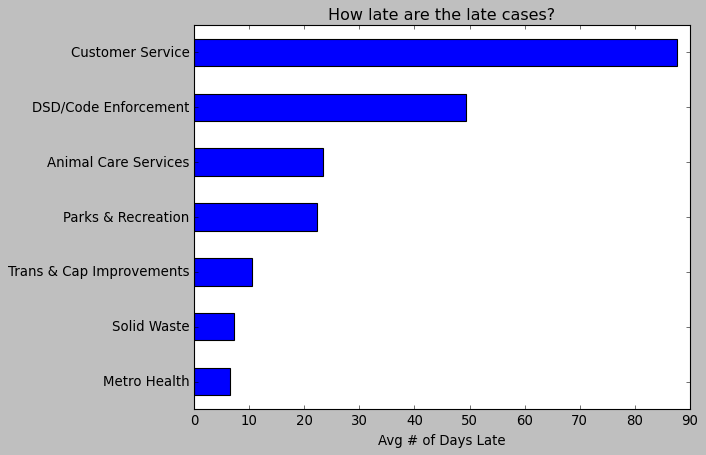

In [35]:
(
    df.filter("case_late")
    .groupby("department")
    .agg(avg("num_days_late").alias("avg_days_late"))
    .toPandas()
    .set_index("department")
    .avg_days_late.sort_values()
    .plot.barh()
)

plt.gca().set(
    ylabel="",
    xlabel="Avg # of Days Late",
    title="How late are the late cases?",
);

### 4
What is the service type that is the most late? Just for Parks & Rec?


In [36]:
(
    df.filter(df.case_late)
    .filter(df.department == "Parks & Recreation") # comment out this line to see all
    .groupby("service_request_type")
    .agg(round(mean("num_days_late"),2).alias("avg_days_late"))
    .sort(desc("avg_days_late"))
    .limit(20).show()
)

+--------------------+-------------+
|service_request_type|avg_days_late|
+--------------------+-------------+
|Amenity Park Impr...|        76.87|
|Major Park Improv...|        75.79|
|Reservation Assis...|        66.03|
|Park Building Mai...|        59.37|
| Sportfield Lighting|        51.48|
|          Electrical|        42.95|
|        Tree Removal|        40.28|
|Landscape Mainten...|        38.87|
|     Heavy Equipment|        38.57|
|Miscellaneous Par...|        33.62|
|Tree Trimming/Mai...|         30.7|
|General Building ...|        28.19|
|             Masonry|        27.99|
|            Painting|         25.4|
|    Sign Maintenance|        22.28|
|   Fence/Gate Repair|        20.37|
|Small Equipment R...|        19.64|
|               Pools|        19.49|
|            Plumbing|        18.62|
|Plumbing/Drinking...|        18.18|
+--------------------+-------------+



### 5
For the DSD/Code Enforcement department, what are the most common service request types? 
Look at other departments too.

In [37]:
(
    df.filter(col('department') == 'DSD/Code Enforcement')
    .groupby('service_request_type').count()
    .sort(desc('count'))
    .show(truncate = False)
)

+--------------------------------------+-----+
|service_request_type                  |count|
+--------------------------------------+-----+
|Overgrown Yard/Trash                  |65895|
|Bandit Signs                          |32910|
|Front Or Side Yard Parking            |28794|
|Junk Vehicle On Private Property      |21473|
|Alley-Way Maintenance                 |20214|
|Right Of Way/Sidewalk Obstruction     |17699|
|Vacant Lot/Overgrown/Trash            |9329 |
|Minimum Housing-Owner Occupied        |8543 |
|Graffiti: Private Property (Corridors)|8525 |
|Dang. Premises/CL/SEC                 |8004 |
|Minimum Housing-Tenant Occupied       |7984 |
|"Vacant Lot-Private (12"")"           |7875 |
|Brush Violations                      |7475 |
|Permits Building                      |6880 |
|Vacant House Overgrown Yard           |6109 |
|Graffiti: Building                    |4572 |
|Graffiti Public Property              |4104 |
|Low Hanging Limbs on Streets/Sidewalk |4052 |
|CPS Energy W

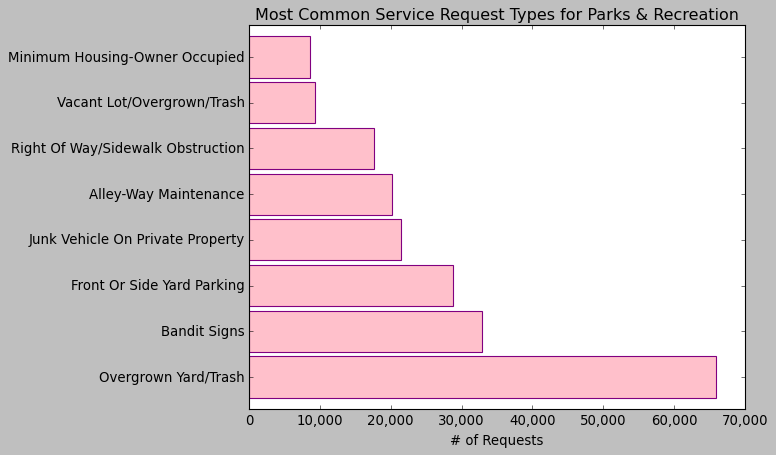

In [40]:
# def format_number_sub_thousands(x, *args):
#     return "{:.0f}k".format(x / 1000)
(
    # comment out / switch the filter statement to view different departments
    df.filter(expr('department == "DSD/Code Enforcement"'))
#     df.filter(expr('department == "Parks & Recreation"'))    
    .groupby("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
    .set_index("service_request_type")["count"]
    .plot.barh(color="pink", width=0.9, ec="purple")
)

plt.gca().set(
    ylabel="",
    xlabel="# of Requests",
    title="Most Common Service Request Types for Parks & Recreation",
)

plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:,.0f}'.format))

### 6
Does whether or not its a weekend matter for when a case is opened/closed?


In [42]:
df.show(2, vertical = True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
-RECORD 1-------------------------

[Text(0.5, 0, ''),
 Text(0, 0.5, '# Cases'),
 Text(0.5, 1.0, 'Total # of Cases Opened By Weekday')]

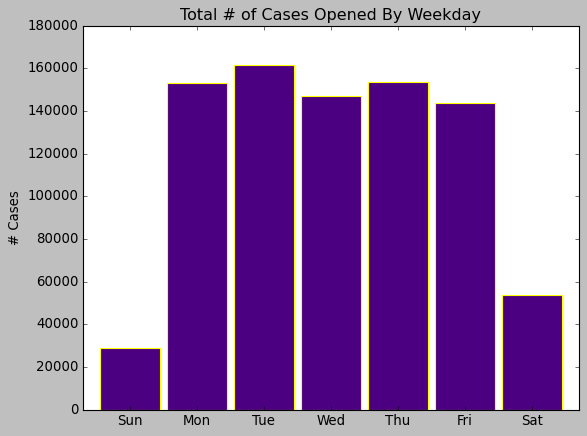

In [45]:
weekdays = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    # the line above is an example of doing the date formatting with spark
    # through the SimpleDateFormat api instead of with python
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    # Here we convert the weekday string to a categorical type with an order.
    # This lets us order the weekdays properly in our visualization.
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar(width=0.9, ec="yellow", color="indigo")
)

plt.xticks(rotation=0)
plt.gca().set(
    xlabel="", ylabel="# Cases", title="Total # of Cases Opened By Weekday"
)

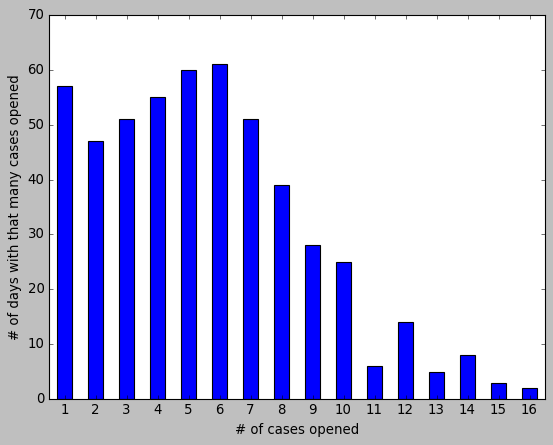

In [46]:
# another way to answer 
(
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()['count']
    .value_counts()
    .sort_index()
    .plot.bar()
)

plt.xlabel("# of cases opened")
plt.ylabel("# of days with that many cases opened")
plt.xticks(rotation=0);

### 7
On average, how many cases are opened a day for the Customer Service department?


In [47]:
(
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
    ['count'].mean()
 )

5.564453125

### 8
Does the number of service requests for the solid waste department vary by day of the week?

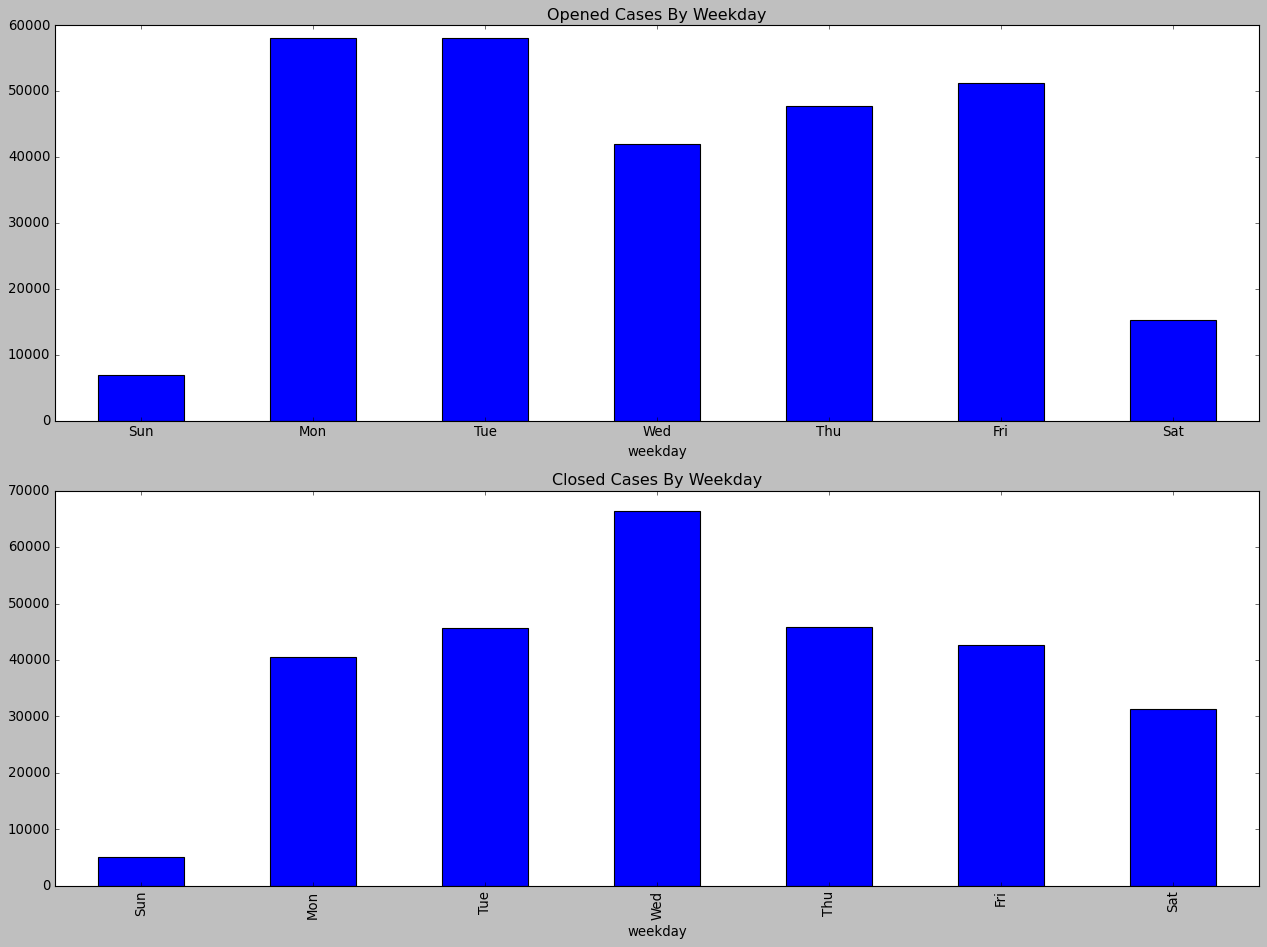

In [48]:
# Does the number of service requests for the solid waste department vary by day of the week? 111

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax1)
)
ax1.set(
    title='Opened Cases By Weekday'
)
ax1.tick_params(axis='x', labelrotation=0)


(
    df.withColumn("weekday", date_format("case_closed_date", "E"))
    .filter(expr('department == "Solid Waste"'))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=weekdays, ordered=True))
    .set_index('weekday')['count']
    .sort_index()
    .plot.bar(ax=ax2)
)
ax2.set(
    title='Closed Cases By Weekday'
)
fig.tight_layout()

In [50]:
# an other way
df = df.withColumn('day_of_the_week_opened', date_format('case_opened_date', 'EEEE'))

In [51]:
df.show(1, vertical = True)

-RECORD 0--------------------------------------
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 case_due_date          | 2020-09-26 00:42:00  
 case_late              | false                
 num_days_late          | -998.5087616000001   
 case_closed            | true                 
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | Closed               
 source_id              | svcCRMLS             
 request_address        | 2315  EL PASO ST,... 
 council_district       | 005                  
 num_weeks_late         | -142.6441088         
 zipcode                | 78207                
 case_age               | 219                  
 days_to_closed         | 0                    
 case_lifetime          | 0                    
 department             | Animal Care Services 
 dept_subject_to_SLA    | true          

In [52]:
(
df
    .where(col('department') == "Solid Waste")
    .groupby(col('day_of_the_week_opened'))
    .count()
    .sort(desc('count'))
    .show()
)

+----------------------+-----+
|day_of_the_week_opened|count|
+----------------------+-----+
|               Tuesday|58120|
|                Monday|58085|
|                Friday|51203|
|              Thursday|47718|
|             Wednesday|41947|
|              Saturday|15312|
|                Sunday| 6885|
+----------------------+-----+

